## 📦 Import Required Libraries and Set Data Directory

This block loads necessary packages and sets the working directory (`/data01/grb_2`) for all downloaded and output files.


In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord
from cosipy import SpacecraftFile, SourceInjector
from histpy import Histogram
from threeML import Band, Model, PointSource
from cosipy.util import fetch_wasabi_file
import shutil
import os

%matplotlib inline

# Set the working directory
data_dir = Path("/data01/grb_2")

## 📥 Download the Instrument Response File

This large file describes how the COSI detector responds to gamma rays from different directions and energies. It's essential for injecting any source.

In [2]:
%%capture
zipped_response_path = data_dir / "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.zip"
response_path = data_dir / "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.h5"

if not response_path.exists():
    fetch_wasabi_file(
        "COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.zip",
        zipped_response_path)
    shutil.unpack_archive(zipped_response_path, data_dir)
    os.remove(zipped_response_path)

## 🛰️ Download the Spacecraft Orientation File

This file contains the simulated pointing direction of the spacecraft over 3 months — required to know where the telescope was looking.


In [4]:
%%capture
orientation_path = data_dir / "20280301_3_month_with_orbital_info.ori"

if not orientation_path.exists():
    fetch_wasabi_file(
        "COSI-SMEX/DC2/Data/Orientation/20280301_3_month_with_orbital_info.ori",
        orientation_path)

## 🔭 Define a Hypothetical GRB-Like Band Spectrum

We use a **Band function**, commonly used to model GRBs, but make it brighter than the Crab by increasing the normalization `K`.

In [6]:
alpha_inj = -1.0
beta_inj = -2.5
E0_inj = 300. * (alpha_inj - beta_inj) * u.keV
xp_inj = E0_inj * (alpha_inj + 2) / (alpha_inj - beta_inj)
piv_inj = 100. * u.keV
K_inj = 5e-3 / u.cm / u.cm / u.s / u.keV  # Brighter than typical GRB

spectrum_inj = Band()
spectrum_inj.alpha.value = alpha_inj
spectrum_inj.beta.value = beta_inj
spectrum_inj.xp.value = xp_inj.value
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.xp.unit = xp_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit

## 📡 Define Sky Location and Create the GRB Source Model

We place the source at a galactic coordinate (l = 120°, b = 15°) and attach the spectrum to it.

In [7]:
# Define a new sky location (not Crab)
source_coord = SkyCoord(l=120.0, b=15.0, frame="galactic", unit="deg")

# Attach the spectrum to a named point source
point_source = PointSource("GRB_sim", l=source_coord.l.deg, b=source_coord.b.deg, spectral_shape=spectrum_inj)

# Create the full source model
model = Model(point_source)

## 🔄 Load the Spacecraft Orientation and Detector Response

Required to simulate how COSI would detect the source across time and pointing direction.

In [10]:
# Load pointing and response data
ori = SpacecraftFile.parse_from_file(orientation_path)
injector = SourceInjector(response_path=response_path)

## 💥 Inject the Simulated GRB Signal

This will generate synthetic detector data as if the bright GRB were seen by COSI during its 3-month scan.


CPU times: user 1min 15s, sys: 4.6 s, total: 1min 19s
Wall time: 1min 26s


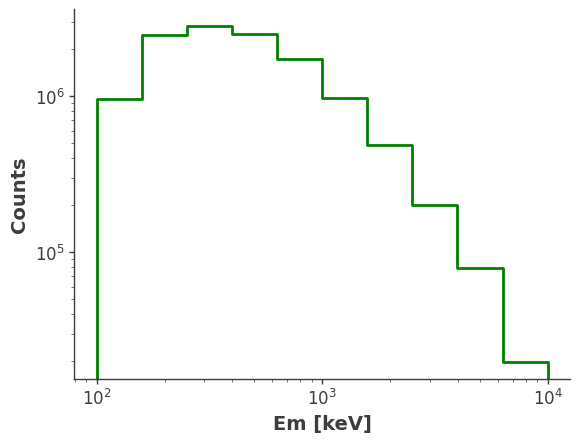

In [11]:
%%time
file_path = data_dir / "GRB_sim_bright_injected.h5"

# Remove old file if present
if file_path.exists():
    os.remove(file_path)

# Inject the GRB into the response using the 3-month orbit data
model_injected = injector.inject_model(model=model, orientation=ori, make_spectrum_plot=True, data_save_path=file_path)


## 📊 Plot: Energy vs. Counts (Injected Spectrum)

This final plot shows the total detected counts as a function of energy, using logarithmic axes for both.


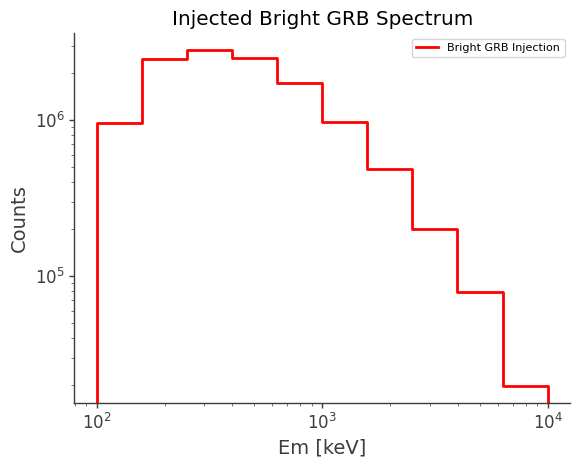

In [12]:
# Load injected histogram and plot projected energy spectrum
injected = Histogram.open(file_path)

ax, plot = injected.project("Em").draw(label="Bright GRB Injection", color="red")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_title("Injected Bright GRB Spectrum")
ax.legend()

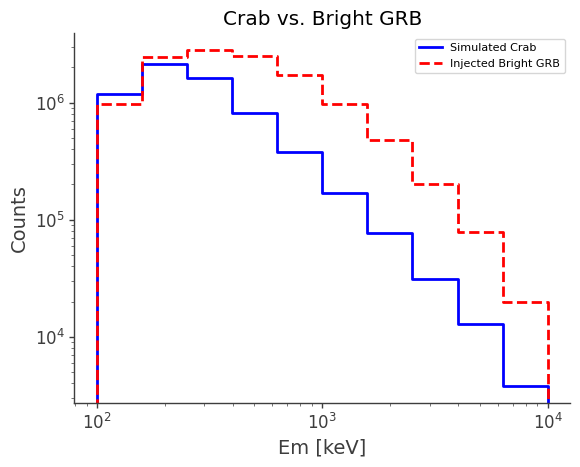

In [13]:
sim_crab = Histogram.open("/data01/grb_2/crab_3months_unbinned_data.hdf5").project("Em")
sim_grb = Histogram.open("/data01/grb_2/GRB_sim_bright_injected.h5").project("Em")

ax, _ = sim_crab.draw(label="Simulated Crab", color="blue")
sim_grb.draw(ax=ax, label="Injected Bright GRB", color="red", linestyle="dashed")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_title("Crab vs. Bright GRB")
ax.legend()